## Audio type conversion

In [3]:
# Audio type conversion

import os
import subprocess
from pathlib import Path

class AudioConverter:


    @staticmethod
    def convert_audio(input_file, output_format, output_file=None, **kwargs):

        if not os.path.exists(input_file):
            print(f"Error: Input file '{input_file}' does not exist.")
            return False

        # Create output filename
        if output_file is None:
            input_path = Path(input_file)
            output_file = str(input_path.with_suffix(f'.{output_format}'))

        # Build ffmpeg command based on output format
        cmd = ['ffmpeg', '-i', input_file, '-y']

        if output_format == 'mp3':
            bitrate = kwargs.get('bitrate', '192k')
            cmd.extend(['-c:a', 'libmp3lame', '-b:a', bitrate])

        elif output_format == 'wav':
            sample_rate = kwargs.get('sample_rate', 44100)
            cmd.extend(['-acodec', 'pcm_s16le', '-ar', str(sample_rate)])

        elif output_format == 'opus':
            bitrate = kwargs.get('bitrate', '128k')
            cmd.extend(['-c:a', 'libopus', '-b:a', bitrate])

        # Add output file
        cmd.append(output_file)

        try:
            subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(f"Successfully converted '{input_file}' to '{output_file}'")
            return True

        except subprocess.CalledProcessError as e:
            print(f"Error during conversion: {e}")
            return False
        except Exception as e:
            print(f"Unexpected error: {e}")
            return False

'\n# Example usage\nif __name__ == "__main__":\n    # MP3 to WAV\n    AudioConverter.convert_audio("input.mp3", "wav", sample_rate=48000)\n\n    # WAV to MP3\n    AudioConverter.convert_audio("input.wav", "mp3", bitrate="320k")\n\n    # OPUS to WAV\n    AudioConverter.convert_audio("input.opus", "wav")\n'

In [4]:
# OPUS to WAV
AudioConverter.convert_audio("/content/Angry.opus", "wav")

Successfully converted '/content/Angry.opus' to '/content/Angry.wav'


True

In [5]:
# WAV to MP3
AudioConverter.convert_audio("/content/Angry.wav", "mp3", bitrate="320k")

Successfully converted '/content/Angry.wav' to '/content/Angry.mp3'


True

##Install vosk (audio to text)

In [1]:
# Install Vosk
!pip install vosk

# For audio conversion
!pip install pydub

# For handling MP3 files
!pip install ffmpeg-python

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 74.1 MB/s eta 0:00:00
  Created wheel for srt: filename=srt-3.5.3-py3-none-any.whl size=22427 sha256=3520b534e40d2030a31d5aa1051d9ea20ae6c539d4c2ae5279182f7b41974932
  Stored in directory: /root/.cache/pip/wheels/1f/43/f1/23ee9119497fcb57d9f7046fbf34c6d9027c46a1fa7824cf08
Successfully built srt


In [6]:
import json
import wave
import os
from vosk import Model, KaldiRecognizer, SetLogLevel
import subprocess
from pydub import AudioSegment

def convert_to_wav(input_file, output_file=None):
    """Convert any audio format to WAV format suitable for Vosk"""
    if output_file is None:
        output_file = os.path.splitext(input_file)[0] + '_converted.wav'

    try:
        audio = AudioSegment.from_file(input_file)
        # Convert to mono
        audio = audio.set_channels(1)
        # Convert to 16-bit PCM
        audio = audio.set_sample_width(2)
        # Set sample rate to 16kHz for better recognition
        audio = audio.set_frame_rate(16000)
        # Export as WAV
        audio.export(output_file, format="wav")
        print(f"Converted {input_file} to {output_file}")
        return output_file
    except Exception as e:
        print(f"Error converting audio: {e}")
        return None

def download_vosk_model(model_name="vosk-model-small-en-us-0.15"):
    # Download a Vosk model if not already present
    import urllib.request
    import zipfile

    model_path = model_name
    if os.path.exists(model_path):
        print(f"Model {model_name} already exists")
        return model_path

    print(f"Downloading {model_name}...")
    model_url = f"https://alphacephei.com/vosk/models/{model_name}.zip"
    zip_path = f"{model_name}.zip"

    try:
        urllib.request.urlretrieve(model_url, zip_path)

        print("Extracting model...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(".")

        os.remove(zip_path)
        print(f"Model downloaded and extracted to {model_path}")
        return model_path
    except Exception as e:
        print(f"Error downloading model: {e}")
        return None

def transcribe_audio_vosk(audio_file_path, model_name="vosk-model-small-en-us-0.15"):

    # Reduce Vosk logging
    SetLogLevel(-1)

    try:
        # Check if file exists
        if not os.path.exists(audio_file_path):
            return f"Error: File {audio_file_path} not found"

        # Convert audio to WAV format if needed
        file_ext = os.path.splitext(audio_file_path)[1].lower()
        if file_ext != '.wav':
            print("Converting audio to WAV format...")
            wav_file = convert_to_wav(audio_file_path)
            if not wav_file:
                return "Error converting audio to WAV format"
        else:
            wav_file = audio_file_path

        # Download or use existing model
        model_path = download_vosk_model(model_name)
        if not model_path:
            return "Error downloading model"

        print(f"Loading Vosk model...")
        model = Model(model_path)

        # Open audio file
        wf = wave.open(wav_file, "rb")

        # Check if the WAV file has the right format
        if wf.getnchannels() != 1:
            return "Audio file must be mono channel WAV format"

        # Create recognizer
        rec = KaldiRecognizer(model, wf.getframerate())
        rec.SetWords(True)

        # Process audio file
        print("Transcribing audio...")
        results = []

        # Process in chunks to show progress
        chunk_size = 4000
        total_frames = wf.getnframes()
        processed_frames = 0

        while True:
            data = wf.readframes(chunk_size)
            processed_frames += chunk_size

            # Show progress
            progress = min(100, int(processed_frames / total_frames * 100))
            print(f"Progress: {progress}%", end="\r")

            if len(data) == 0:
                break

            if rec.AcceptWaveform(data):
                part_result = json.loads(rec.Result())
                results.append(part_result.get('text', ''))

        # Get final result
        part_result = json.loads(rec.FinalResult())
        results.append(part_result.get('text', ''))

        # Combine results
        transcription = ' '.join(results)
        print("\nTranscription complete!")

        return transcription

    except Exception as e:
        return f"Error transcribing audio: {e}"

# Example usage
if __name__ == "__main__":
    # Single file transcription
    audio_file = "/content/Angry.mp3"  # Can be any format

    text = transcribe_audio_vosk(audio_file, model_name="vosk-model-small-en-us-0.15")

    print("\nTranscription Result:")
    print(text)

Converting audio to WAV format...
Converted /content/Angry.mp3 to /content/Angry_converted.wav
Extracting model...
Model downloaded and extracted to vosk-model-small-en-us-0.15
Loading Vosk model...
Transcribing audio...
Progress: 100%
Transcription complete!

Transcription Result:
don't you understand that i'm poems korea 


In [7]:
import pandas as pd
import IPython.display as ipd
ipd.Audio('/content/Angry.mp3')

## Approach 1

### Load libraries and Audio

In [21]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers.pipelines.text_classification")

In [8]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from IPython.display import Audio, display
import time
import json
from datetime import datetime

# For text sentiment analysis
from transformers import pipeline

# For audio processing
import wave
from vosk import Model, KaldiRecognizer, SetLogLevel

# For visualization
import seaborn as sns

# Set up logging
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Track execution time (to be completed)
start_time = time.time()
logger.info("Setting up environment...")

# Create a directory for model downloads if it doesn't exist
os.makedirs("models", exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [9]:
def load_and_preprocess_audio(audio_path, display_plots=True):

    logger.info(f"Loading audio file: {audio_path}")

    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Display basic information
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"Audio duration: {duration:.2f} seconds")
    print(f"Sampling rate: {sr} Hz")

    # Normalize audio
    y = librosa.util.normalize(y)

    if display_plots:

        # Plot waveform
        plt.figure(figsize=(14, 5))
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Waveform')

        # Plot spectrogram
        plt.subplot(2, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.tight_layout()
        plt.show()

        # Play audio
        display(Audio(y, rate=sr))

    return y, sr

# Example usage
# y, sr = load_and_preprocess_audio('path_to_your_audio_file.wav')

### Audio to Text

In [10]:
def download_vosk_model(model_name="vosk-model-small-en-us-0.15"):

    import urllib.request
    import zipfile

    model_path = os.path.join("models", model_name)
    if os.path.exists(model_path):
        logger.info(f"Model {model_name} already exists")
        return model_path

    logger.info(f"Downloading {model_name}...")
    model_url = f"https://alphacephei.com/vosk/models/{model_name}.zip"
    zip_path = os.path.join("models", f"{model_name}.zip")

    try:
        urllib.request.urlretrieve(model_url, zip_path)

        logger.info("Extracting model...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("models")

        os.remove(zip_path)
        logger.info(f"Model downloaded and extracted to {model_path}")
        return model_path
    except Exception as e:
        logger.error(f"Error downloading model: {e}")
        return None

def transcribe_audio_vosk(audio_path, model_name="vosk-model-small-en-us-0.15"):

    # Reduce Vosk logging
    SetLogLevel(-1)

    # Ensure we have the model
    model_path = download_vosk_model(model_name)
    if not model_path:
        return "Error downloading model"

    logger.info(f"Transcribing audio: {audio_path}")
    start_time = time.time()

    try:
        # Check if file exists
        if not os.path.exists(audio_path):
            return f"Error: File {audio_path} not found"

        # Load model
        model = Model(model_path)

        # Open audio file
        wf = wave.open(audio_path, "rb")

        # Create recognizer
        rec = KaldiRecognizer(model, wf.getframerate())
        rec.SetWords(True)

        # Process audio file
        results = []

        while True:
            data = wf.readframes(4000)
            if len(data) == 0:
                break

            if rec.AcceptWaveform(data):
                part_result = json.loads(rec.Result())
                results.append(part_result.get('text', ''))

        # Get final result
        part_result = json.loads(rec.FinalResult())
        results.append(part_result.get('text', ''))

        # Combine results
        transcription = ' '.join(results)

        elapsed_time = time.time() - start_time
        logger.info(f"Transcription completed in {elapsed_time:.2f} seconds")

        return transcription

    except Exception as e:
        logger.error(f"Error transcribing audio: {e}")
        return f"Error: {str(e)}"


In [11]:
text = transcribe_audio_vosk('/content/Angry.wav')
print(f"Transcribed text: {text}")

Transcribed text: don't you understand that i'm poems korea 


### Text sentiments

In [27]:
def analyze_text_emotion(text):

    logger.info("Analyzing text emotion...")
    start_time = time.time()

    # Initialize the emotion classifier
    emotion_classifier = pipeline(
        "text-classification",
        model="j-hartmann/emotion-english-distilroberta-base",
        top_k=None  # Replaces deprecated return_all_scores=True
    )

    # Get emotion scores (returns a list of dicts)
    emotion_scores = emotion_classifier(text)[0]

    # Convert to dictionary format: {'joy': 0.65, 'sadness': 0.12, ...}
    emotions = {item['label'].lower(): item['score'] for item in emotion_scores}

    # Determine dominant emotion
    dominant_emotion = max(emotions.items(), key=lambda x: x[1])

    elapsed_time = time.time() - start_time
    logger.info(f"Text emotion analysis completed in {elapsed_time:.2f} seconds")

    # Plot emotion distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(emotions.keys()), y=list(emotions.values()))
    plt.title('Text-Based Emotion Analysis')
    plt.ylabel('Probability')
    plt.xlabel('Emotion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'emotions': emotions,
        'dominant_emotion': dominant_emotion[0],
        'confidence': dominant_emotion[1]
    }


Device set to use cuda:0


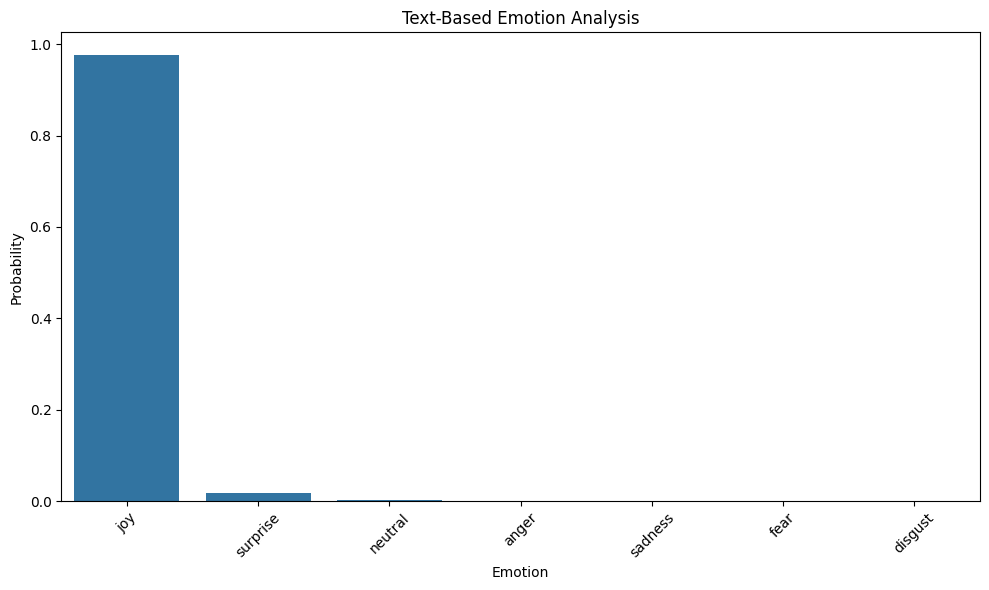

{'emotions': {'joy': 0.9769970178604126, 'surprise': 0.01708710938692093, 'neutral': 0.0024263709783554077, 'anger': 0.0012638752814382315, 'sadness': 0.0011247042566537857, 'fear': 0.0006264987168833613, 'disgust': 0.0004743832687381655}, 'dominant_emotion': 'joy', 'confidence': 0.9769970178604126}


In [28]:
# Example Usage
text_results = analyze_text_emotion("I'm really happy about this amazing project!")
print(text_results)

### Audio Sentiments

#### Ideal format

In [15]:
def extract_audio_features(y, sr):

    logger.info("Extracting audio features...")

    features = {}

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features['mfcc_mean'] = np.mean(mfccs, axis=1)
    features['mfcc_std'] = np.std(mfccs, axis=1)

    # Extract spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)

    # Extract energy/volume features
    features['rms_energy'] = np.mean(librosa.feature.rms(y=y)[0])

    # Extract pitch features
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    features['pitch_mean'] = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0

    # Extract zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features['zcr_mean'] = np.mean(zcr)

    return features

def analyze_audio_emotion(y, sr):

    logger.info("Analyzing audio emotion...")
    start_time = time.time()

    # Extract features
    features = extract_audio_features(y, sr)

    emotions = {
        'joy': 0.0,
        'sadness': 0.0,
        'anger': 0.0,
        'fear': 0.0,
        'surprise': 0.0,
        'disgust': 0.0,
        'neutral': 0.0
    }

    # Higher energy often correlates with joy, anger, or surprise
    energy = features['rms_energy']
    if energy > 0.1:  # Arbitrary threshold
        emotions['joy'] += 0.3
        emotions['anger'] += 0.2
        emotions['surprise'] += 0.2
    else:
        emotions['sadness'] += 0.3
        emotions['neutral'] += 0.2

    # Higher pitch variation might indicate surprise or fear
    pitch_mean = features['pitch_mean']
    if pitch_mean > 200:  # Arbitrary threshold
        emotions['surprise'] += 0.2
        emotions['fear'] += 0.1

    # Higher zero-crossing rate might indicate anger or fear
    zcr = features['zcr_mean']
    if zcr > 0.05:  # Arbitrary threshold
        emotions['anger'] += 0.2
        emotions['fear'] += 0.2

    # Normalize to sum to 1
    total = sum(emotions.values())
    emotions = {k: v/total for k, v in emotions.items()}

    # Find dominant emotion
    dominant_emotion = max(emotions.items(), key=lambda x: x[1])

    elapsed_time = time.time() - start_time
    logger.info(f"Audio emotion analysis completed in {elapsed_time:.2f} seconds")

    # Visualize results
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(emotions.keys()), y=list(emotions.values()))
    plt.title('Audio-Based Emotion Analysis')
    plt.ylabel('Probability')
    plt.xlabel('Emotion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'emotions': emotions,
        'dominant_emotion': dominant_emotion[0],
        'confidence': dominant_emotion[1]
    }


#### Audio Sentiment Model trained on RAVDESS,etc datasets

In [16]:
import torch
import librosa
import numpy as np
import torch.nn as nn

class AudioModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(AudioModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 256, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv4 = nn.Conv1d(128, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(9536, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool3(x)
        x = self.dropout1(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Feature extraction functions
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                      ))
    return result

def preprocess_audio(file_path):
    # Load audio file
    data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)

    # Extract features
    features = extract_features(data, sample_rate)

    return features

def predict_emotion(file_path, model_path='audio_model.pth'):
    # Define emotion labels
    emotion_labels = ['disgust', 'sad', 'fear', 'angry', 'happy', 'neutral', 'surprise']

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = AudioModel(input_shape=(2376,), num_classes=7)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Preprocess audio
    features = preprocess_audio(file_path)

    # Ensure features have the right shape
    if features.shape[0] != 2376:
        # If features are too short, pad with zeros
        if features.shape[0] < 2376:
            features = np.pad(features, (0, 2376 - features.shape[0]), 'constant')
        # If features are too long, truncate
        else:
            features = features[:2376]

    # Convert to tensor and add batch and channel dimensions
    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(features_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_emotion = emotion_labels[predicted.item()]

    return predicted_emotion

# Example usage
if __name__ == "__main__":
    # Replace with your audio file path
    audio_file = "/content/Angry.wav"

    # Replace with your model path
    model_path = "/content/audio_model.pth"

    emotion = predict_emotion(audio_file, model_path)
    print(f"The predicted emotion is: {emotion}")

The predicted emotion is: fear


#### Audio Sentiments in our ideal format

In [22]:
def extract_audio_features_deep(y, sr, expected_shape=2376):

    logger.info("Extracting audio features for deep model...")

    def zcr(data, frame_length=2048, hop_length=512):
        return np.squeeze(librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length))

    def rmse(data, frame_length=2048, hop_length=512):
        return np.squeeze(librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length))

    def mfcc(data, sr, frame_length=2048, hop_length=512):
        return np.ravel(librosa.feature.mfcc(y=data, sr=sr).T)

    result = np.hstack((zcr(y), rmse(y), mfcc(y, sr)))

    # Pad or truncate to expected length
    if result.shape[0] < expected_shape:
        result = np.pad(result, (0, expected_shape - result.shape[0]), 'constant')
    else:
        result = result[:expected_shape]

    features_tensor = torch.tensor(result, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return features_tensor


In [23]:
def analyze_audio_emotion_deep(y, sr, model_path="audio_model.pth"):

    logger.info("Analyzing audio emotion using deep learning...")
    start_time = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize and load model
    model = AudioModel(input_shape=(2376,), num_classes=7)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Extract features and move to device
    features_tensor = extract_audio_features_deep(y, sr).to(device)

    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    emotion_labels = ['disgust', 'sad', 'fear', 'angry', 'happy', 'neutral', 'surprise']
    emotions = {label: float(prob) for label, prob in zip(emotion_labels, probabilities)}
    dominant_emotion = max(emotions.items(), key=lambda x: x[1])

    elapsed_time = time.time() - start_time
    logger.info(f"Deep audio emotion analysis completed in {elapsed_time:.2f} seconds")

    # Visualize
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(emotions.keys()), y=list(emotions.values()))
    plt.title('Audio-Based Emotion Analysis (Deep Model)')
    plt.ylabel('Probability')
    plt.xlabel('Emotion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'emotions': emotions,
        'dominant_emotion': dominant_emotion[0],
        'confidence': dominant_emotion[1]
    }


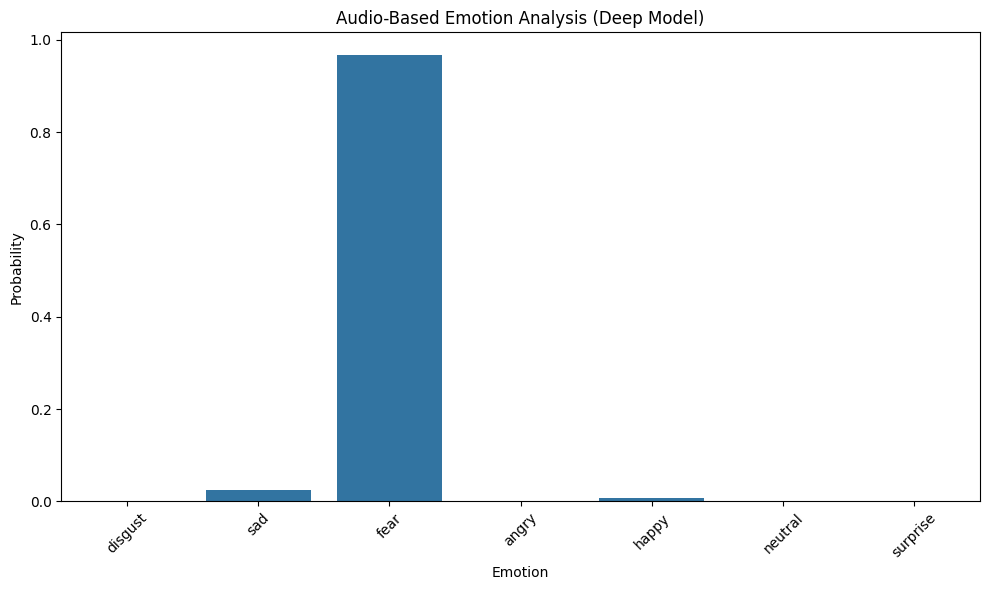

{'emotions': {'disgust': 8.289807642419822e-13, 'sad': 0.025006823241710663, 'fear': 0.9677583575248718, 'angry': 1.4810683426140741e-16, 'happy': 0.0072348397225141525, 'neutral': 2.8603556155581966e-12, 'surprise': 1.9124686209681663e-11}, 'dominant_emotion': 'fear', 'confidence': 0.9677583575248718}


In [24]:
if __name__ == "__main__":
    import librosa
    import logging
    import time
    import seaborn as sns
    import matplotlib.pyplot as plt

    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger()

    audio_path = "/content/Angry.wav"
    model_path = "/content/audio_model.pth"
    y, sr = librosa.load(audio_path, duration=2.5, offset=0.6)

    result = analyze_audio_emotion_deep(y, sr, model_path=model_path)
    print(result)


### Weighted Fusion of Results

In [31]:
def fuse_emotions(text_results, audio_results, text_weight=0.6):

    logger.info(f"Fusing emotions with text_weight={text_weight}...")

    # Get emotion probabilities
    text_emotions = text_results['emotions']
    audio_emotions = audio_results['emotions']

    # Ensure both have the same emotions
    all_emotions = set(text_emotions.keys()).union(set(audio_emotions.keys()))

    # Initialize fused emotions
    fused_emotions = {}

    # Weighted average of probabilities
    for emotion in all_emotions:
        text_prob = text_emotions.get(emotion, 0.0)
        audio_prob = audio_emotions.get(emotion, 0.0)
        fused_emotions[emotion] = (text_weight * text_prob) + ((1 - text_weight) * audio_prob)

    # Find dominant emotion
    dominant_emotion = max(fused_emotions.items(), key=lambda x: x[1])

    # Visualize comparison
    emotions = list(fused_emotions.keys())

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'Emotion': emotions * 3,
        'Probability': list(text_emotions.get(e, 0) for e in emotions) +
                      list(audio_emotions.get(e, 0) for e in emotions) +
                      list(fused_emotions.get(e, 0) for e in emotions),
        'Source': ['Text'] * len(emotions) + ['Audio'] * len(emotions) + ['Fused'] * len(emotions)
    })

    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Emotion', y='Probability', hue='Source', data=df)
    plt.title('Comparison of Text, Audio, and Fused Emotion Analysis')
    plt.ylabel('Probability')
    plt.xlabel('Emotion')
    plt.xticks(rotation=45)
    plt.legend(title='Source')
    plt.tight_layout()
    plt.show()

    return {
        'emotions': fused_emotions,
        'dominant_emotion': dominant_emotion[0],
        'confidence': dominant_emotion[1]
    }



Device set to use cuda:0


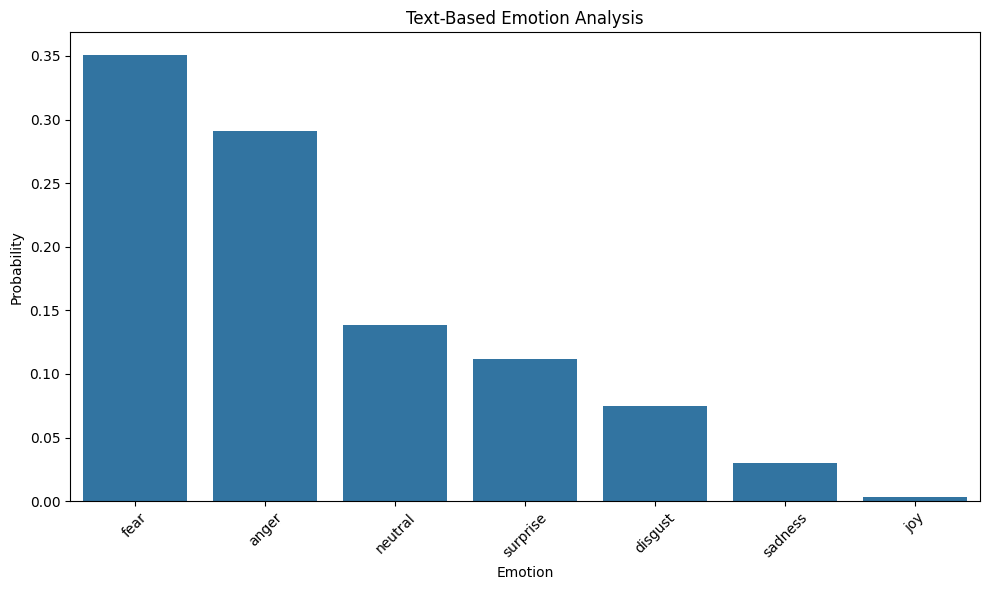

Text emotion: {'emotions': {'fear': 0.3510044813156128, 'anger': 0.29135823249816895, 'neutral': 0.13824638724327087, 'surprise': 0.11206310987472534, 'disgust': 0.07474271953105927, 'sadness': 0.029707204550504684, 'joy': 0.002877881284803152}, 'dominant_emotion': 'fear', 'confidence': 0.3510044813156128}
Text dominant emotion: fear with confidence 0.35


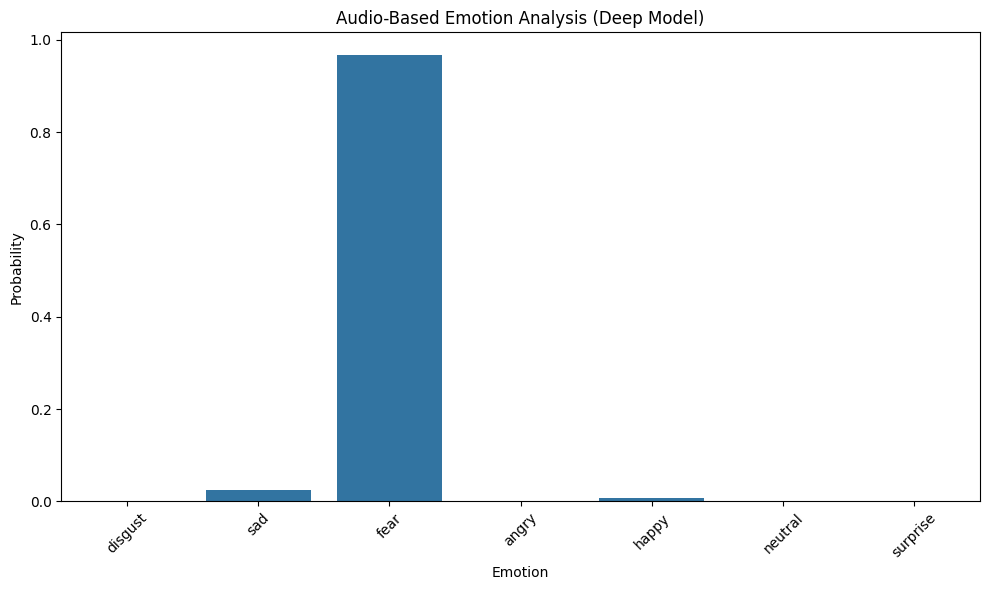

Audio emotion: {'emotions': {'disgust': 8.289807642419822e-13, 'sad': 0.025006823241710663, 'fear': 0.9677583575248718, 'angry': 1.4810683426140741e-16, 'happy': 0.0072348397225141525, 'neutral': 2.8603556155581966e-12, 'surprise': 1.9124686209681663e-11}, 'dominant_emotion': 'fear', 'confidence': 0.9677583575248718}
Audio dominant emotion: fear with confidence 0.97


In [44]:
# Text Sentiments
text = str(transcribe_audio_vosk('/content/Angry.wav'))
text_results = analyze_text_emotion(text)
print(f"Text emotion: {text_results}")
print(f"Text dominant emotion: {text_results['dominant_emotion']} with confidence {text_results['confidence']:.2f}")

# Audio Sentiments
audio_path = "/content/Angry.wav"
model_path = "/content/audio_model.pth"
y, sr = librosa.load(audio_path, duration=2.5, offset=0.6)
audio_results = analyze_audio_emotion_deep(y, sr, model_path=model_path)  # should return full dict like text_results
print(f"Audio emotion: {audio_results}")
print(f"Audio dominant emotion: {audio_results['dominant_emotion']} with confidence {audio_results['confidence']:.2f}")


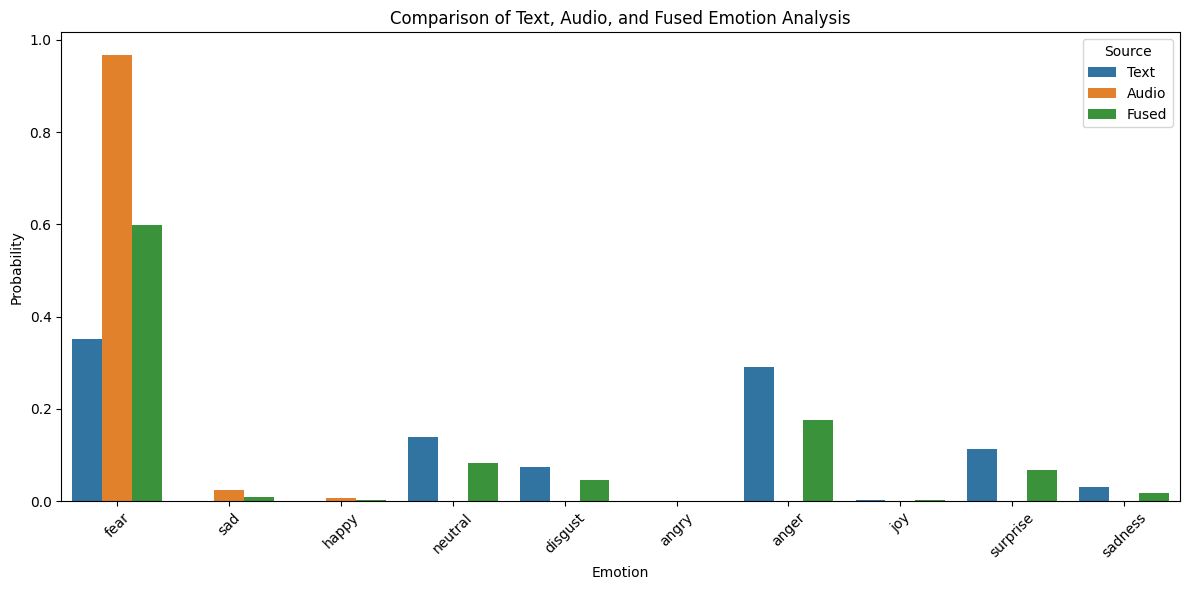

Fused emotion: {'emotions': {'fear': 0.5977060317993164, 'sad': 0.010002729296684266, 'happy': 0.002893935889005661, 'neutral': 0.08294783234710666, 'disgust': 0.04484563171896715, 'angry': 5.924273370456297e-17, 'anger': 0.17481493949890137, 'joy': 0.0017267287708818912, 'surprise': 0.06723786593248508, 'sadness': 0.01782432273030281}, 'dominant_emotion': 'fear', 'confidence': 0.5977060317993164}
Fused dominant emotion: fear with confidence 0.60


In [47]:
# Fused Results
fused_results = fuse_emotions(text_results, audio_results, text_weight=0.6)
print(f"Fused emotion: {fused_results}")
print(f"Fused dominant emotion: {fused_results['dominant_emotion']} with confidence {fused_results['confidence']:.2f}")

### Emojis Mapping

In [41]:
def map_emotion_to_emoji(emotion, intensity=None):

    # Define emotion to emoji mapping with intensity levels
    emotion_emoji_map = {
        'joy': {
            'low': '🙂',
            'medium': '😊',
            'high': '😄'
        },
        'sadness': {
            'low': '😐',
            'medium': '😔',
            'high': '😢'
        },
        'anger': {
            'low': '😒',
            'medium': '😠',
            'high': '😡'
        },
        'fear': {
            'low': '😟',
            'medium': '😨',
            'high': '😱'
        },
        'surprise': {
            'low': '😮',
            'medium': '😲',
            'high': '😱'
        },
        'disgust': {
            'low': '😕',
            'medium': '🤢',
            'high': '🤮'
        },
        'neutral': {
            'low': '😐',
            'medium': '😐',
            'high': '😐'
        }
    }

    # If emotion not in mapping, return neutral
    if emotion not in emotion_emoji_map:
        return '😐'

    # If intensity not provided, use medium
    if intensity is None:
        return emotion_emoji_map[emotion]['medium']

    # Return emoji based on emotion and intensity
    return emotion_emoji_map[emotion][intensity]

def enhance_text_with_emoji(text, emotion, confidence):

    # Determine intensity based on confidence
    if confidence < 0.4:
        intensity = 'low'
    elif confidence < 0.7:
        intensity = 'medium'
    else:
        intensity = 'high'

    # Get emoji
    emoji = map_emotion_to_emoji(emotion, intensity)

    # Add emoji to text
    enhanced_text = f"{text} {emoji}"

    return enhanced_text


In [48]:
# Extract emotion and confidence
detected_emotion = fused_results['dominant_emotion']
confidence_score = fused_results['confidence']
input_text = text

# Enhance text with emoji
enhanced_text = enhance_text_with_emoji(input_text, detected_emotion, confidence_score)

# Output
print("Enhanced text:", enhanced_text)


Enhanced text: don't you understand that i'm poems korea  😨


### Performance Metrics

### Main Function to Run the Complete Pipeline

In [54]:
def process_audio_file(audio_path, text_weight=0.6):

  # Text Sentiments
  text = str(transcribe_audio_vosk(audio_path))
  text_results = analyze_text_emotion(text)

  # Audio Sentiments
  model_path = "/content/audio_model.pth"
  y, sr = librosa.load(audio_path, duration=2.5, offset=0.6)
  audio_results = analyze_audio_emotion_deep(y, sr, model_path=model_path)

  # Fused Results
  fused_results = fuse_emotions(text_results, audio_results, text_weight=0.6)
  print(f"Fused emotion: {fused_results}")
  print(f"Fused dominant emotion: {fused_results['dominant_emotion']} with confidence {fused_results['confidence']:.2f}")

  # Extract emotion and confidence
  detected_emotion = fused_results['dominant_emotion']
  confidence_score = fused_results['confidence']
  input_text = text

  # Enhance text with emoji
  enhanced_text = enhance_text_with_emoji(input_text, detected_emotion, confidence_score)

  # Output
  print("Enhanced text:", enhanced_text)

Device set to use cuda:0


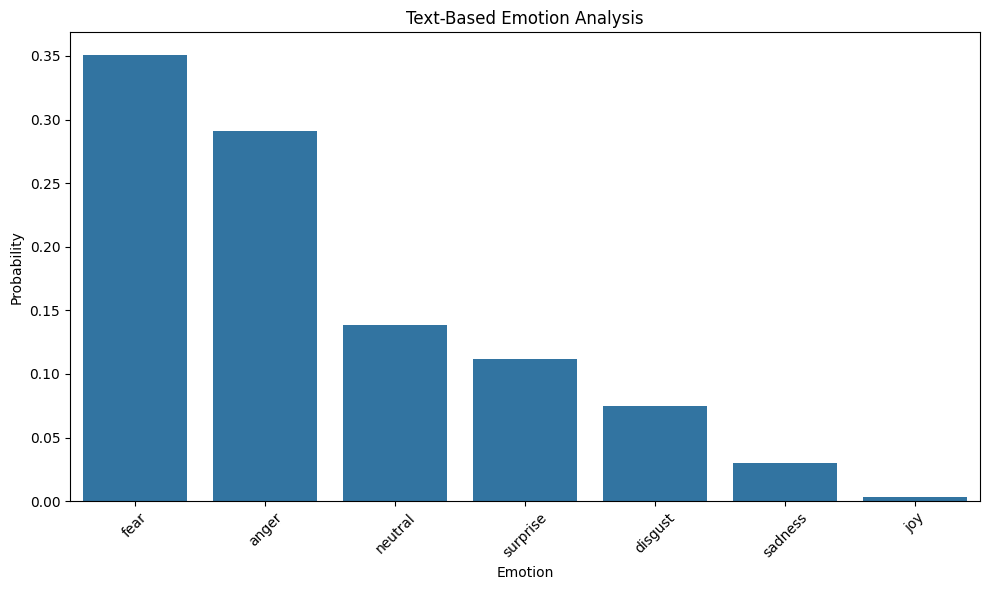

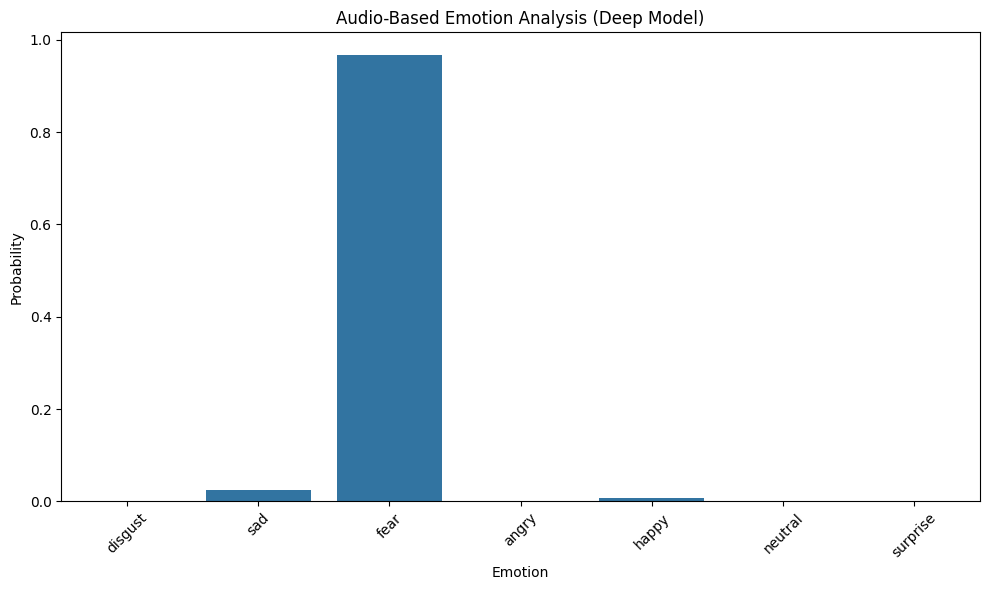

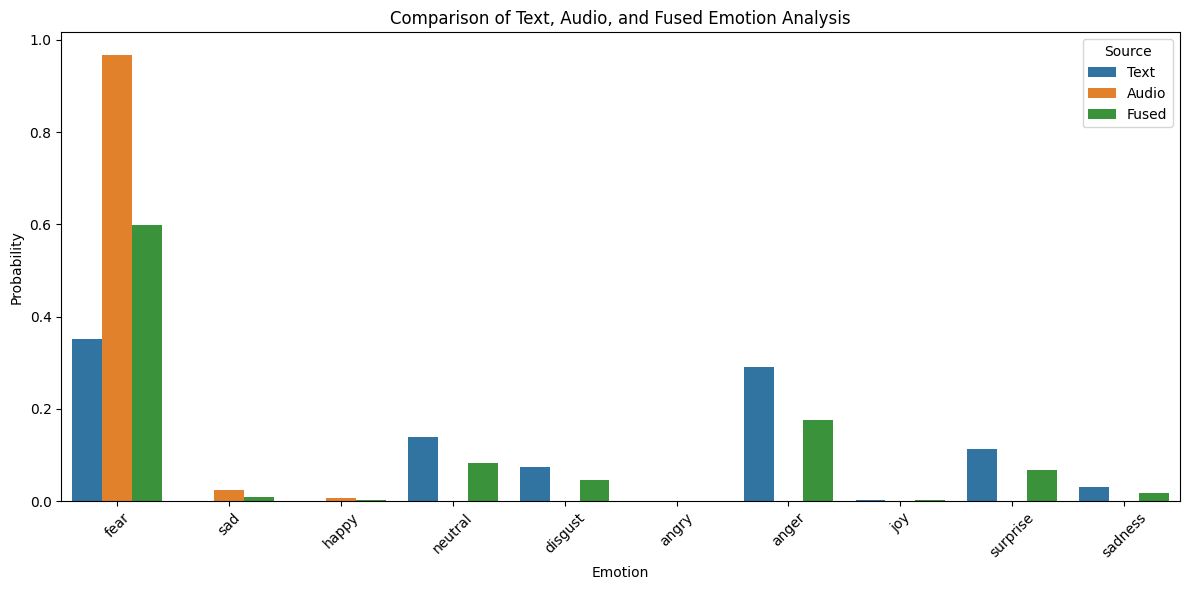

Fused emotion: {'emotions': {'fear': 0.5977060317993164, 'sad': 0.010002729296684266, 'happy': 0.002893935889005661, 'neutral': 0.08294783234710666, 'disgust': 0.04484563171896715, 'angry': 5.924273370456297e-17, 'anger': 0.17481493949890137, 'joy': 0.0017267287708818912, 'surprise': 0.06723786593248508, 'sadness': 0.01782432273030281}, 'dominant_emotion': 'fear', 'confidence': 0.5977060317993164}
Fused dominant emotion: fear with confidence 0.60
Enhanced text: don't you understand that i'm poems korea  😨


In [55]:
process_audio_file('/content/Angry.wav', text_weight=0.6)